# PRICE HOUSING PREDICTION

For this analysis we use the California Housing dataset found on the Kaggle Data Repository.

This data has features such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data.

The objective of the analysis is to predict median house prices in different regions of California as per the 1990 census data.

It is a supervised learning task: a multiple regression problem (univariate, since there's only one value to predict for each district).

In [148]:
#Import some libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from pandas import DataFrame

#Warnings configuration
import warnings
warnings.filterwarnings('ignore')

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from seaborn import distplot
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import scatter_matrix
import patsy
import folium as folium
from folium import plugins
from folium.plugins import HeatMap

#Preprocessing
from sklearn import preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import skew
from scipy.stats import kurtosis

#Modeling
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 1. Data overview

In [2]:
raw_data=pd.read_csv('housing.csv')

In [3]:
df=raw_data.copy()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
print('The dataset has',df.shape[0],'rows and',df.shape[1],'columns.')

The dataset has 20640 rows and 10 columns.


In [5]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

All features are numerical, except from 'ocean proximity', which type is object.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Almost all featrures have non-null values, except for 'total bedrooms'.

In [7]:
# Identify and calculate the percentage of the missing values in each attribute
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values= missing_values.to_frame(name='num_missing')

missing_values['% missing'] = (missing_values['num_missing']/df.shape[0])*100
for index, row in missing_values.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,row['num_missing'],row['% missing']))

For "total_bedrooms" the number of missing values are: 207 (1%)


In [8]:
#Duplicate values
df.duplicated().values.any()

False

There are no duplicate values.

In [9]:
df.describe(include='all').round(0).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
longitude,20640.0,NaN,NaN,NaN,-120.0,2.0,-124.0,-122.0,-118.0,-118.0,-114.0
latitude,20640.0,NaN,NaN,NaN,36.0,2.0,33.0,34.0,34.0,38.0,42.0
housing_median_age,20640.0,NaN,NaN,NaN,29.0,13.0,1.0,18.0,29.0,37.0,52.0
total_rooms,20640.0,NaN,NaN,NaN,2636.0,2182.0,2.0,1448.0,2127.0,3148.0,39320.0
total_bedrooms,20433.0,NaN,NaN,NaN,538.0,421.0,1.0,296.0,435.0,647.0,6445.0
population,20640.0,NaN,NaN,NaN,1425.0,1132.0,3.0,787.0,1166.0,1725.0,35682.0
households,20640.0,NaN,NaN,NaN,500.0,382.0,1.0,280.0,409.0,605.0,6082.0
median_income,20640.0,NaN,NaN,NaN,4.0,2.0,0.0,3.0,4.0,5.0,15.0
median_house_value,20640.0,NaN,NaN,NaN,206856.0,115396.0,14999.0,119600.0,179700.0,264725.0,500001.0
ocean_proximity,20640,5,<1H OCEAN,9136,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
print(df.nunique())

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64


'Ocean proximity' is a categorical feature, which can have 5 possible values.

In [11]:
#profile=df.profile_report(title='Pandas profile - Housing') 
#profile.to_file("Pandas profile - Housing.html")

In [12]:
california_map = folium.Map(location=[36.7783,-119.4179], zoom_start = 6, min_zoom=5)
df_map = df[['latitude', 'longitude']]
data = [[row['latitude'],row['longitude']] for index, row in df_map.iterrows()]
_ = HeatMap(data, radius=10).add_to(california_map)
california_map

# 2. EDA

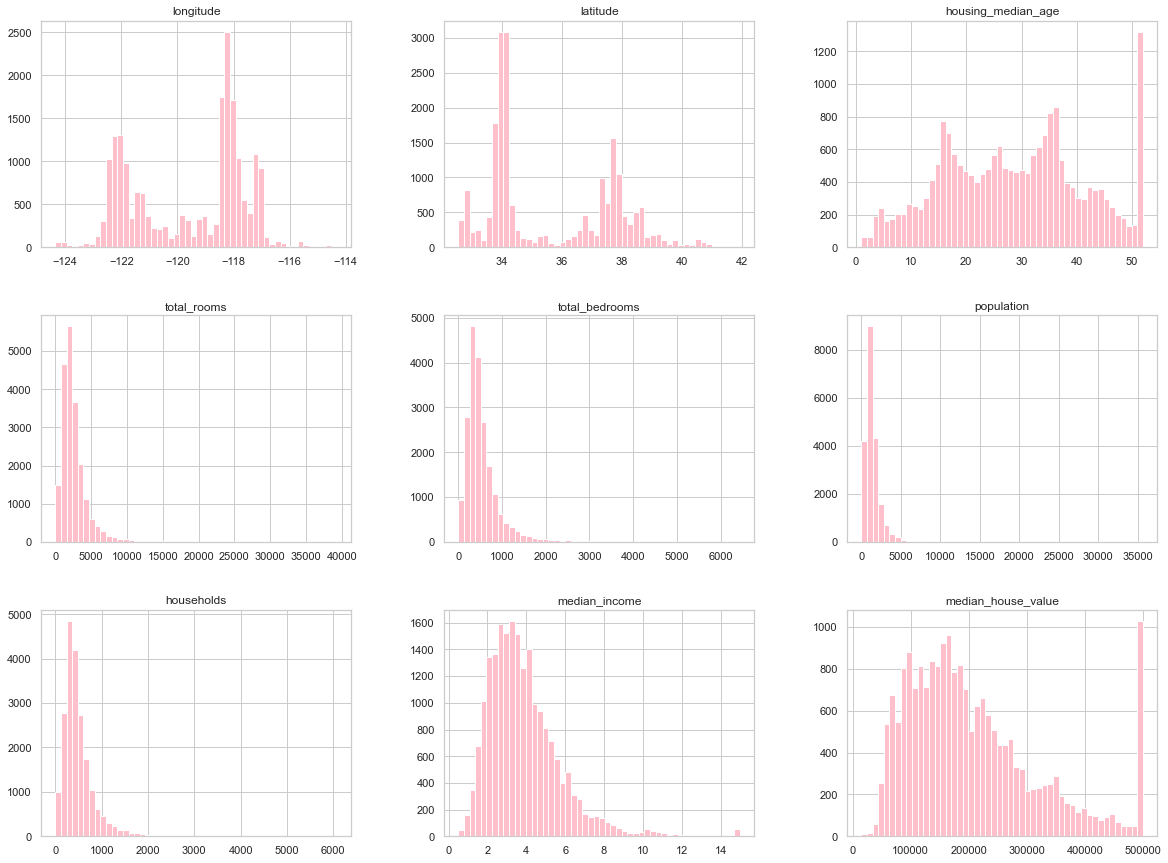

In [13]:
sns.set_theme(style="whitegrid")
sns.set_palette(["pink", "aquamarine","skyblue","lightyellow"])

#Numerical data
df.hist(bins=50, figsize=(20,15))
plt.show();

* Median income: the maximun value is 15 and the minimun, almost 0. It seems that the data has been scaled and cuted at 15 for higher median incomes, and at 0.5 for lower median incomes. The numbers represent tens of thousands of dollars: 5 actually means $50,000
* The maximum total bedrooms is 6445 and the maximum rooms is 39320... This seems a little bit weird.

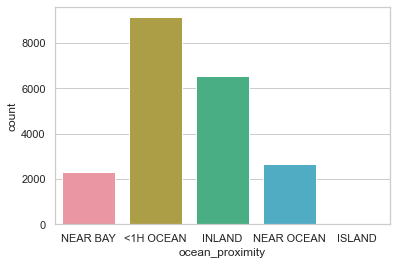

In [14]:
#Categorical data
ax=sns.countplot(df['ocean_proximity'])

In [15]:
# Class level counts for categorical variables.
categorical=['ocean_proximity']
for variable in categorical:
    print(df[variable].value_counts())
    print("\n")

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64




Correlation

In [16]:
correlation=df.corr(method="pearson")
correlation

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


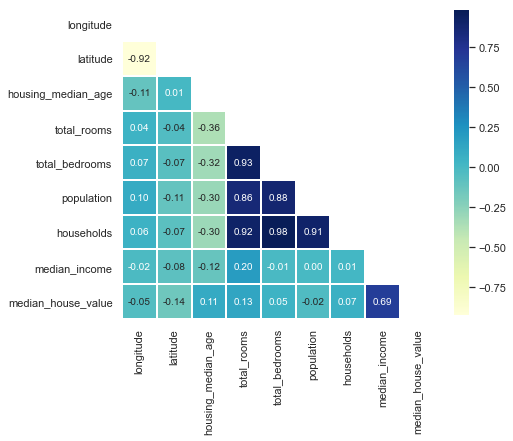

In [17]:
#Heatmap
plt.figure(figsize=(7,7))
sns.set_theme(style="whitegrid")

mask = np.triu(np.ones_like(df.corr(),dtype = bool))

sns.heatmap(correlation, 
            cbar=True, 
            square=True, 
            annot=True,
            linecolor='white',
            linewidths=1,
            fmt='.2f',
            annot_kws={'size': 10},
            cbar_kws={"shrink": 0.8},
            mask=mask,
            cmap="YlGnBu") 

#Roto los ejes
plt.xticks(rotation = 90)

plt.show()

In [18]:
#Let's take a look to the correlation with the target
correlation['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [19]:
#In absolute values
correlation_abs=abs(correlation['median_house_value']).sort_values(ascending=False)
correlation_abs

median_house_value    1.000000
median_income         0.688075
latitude              0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude             0.045967
population            0.024650
Name: median_house_value, dtype: float64

Let’s focus on a few promising attributes that seem most correlated with the median housing value

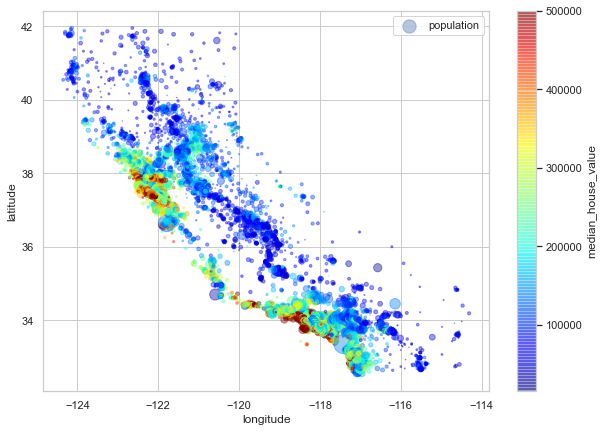

In [20]:
#Plot "median_house_value"
df.plot(kind="scatter", 
        x="longitude", 
        y="latitude", 
        alpha=0.4,
        s=df["population"]/100, 
        label="population", 
        figsize=(10,7),
        c="median_house_value", 
        cmap=plt.get_cmap("jet"), 
        colorbar=True,
        sharex=False)

plt.legend();

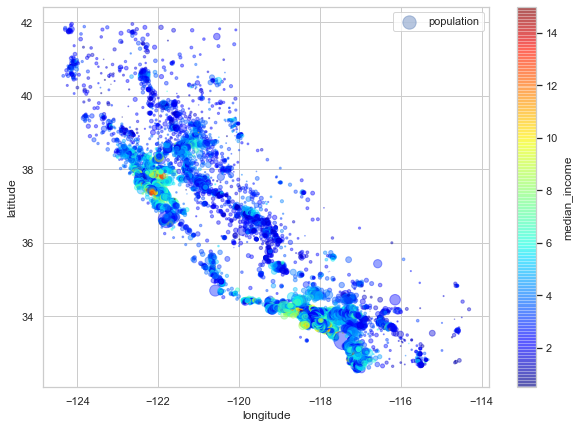

In [21]:
#Plot "median_income"
df.plot(kind="scatter", 
        x="longitude", 
        y="latitude", 
        alpha=0.4,
        s=df["population"]/100, 
        label="population", 
        figsize=(10,7),
        c="median_income", 
        cmap=plt.get_cmap("jet"), 
        colorbar=True,
        sharex=False)

plt.legend();

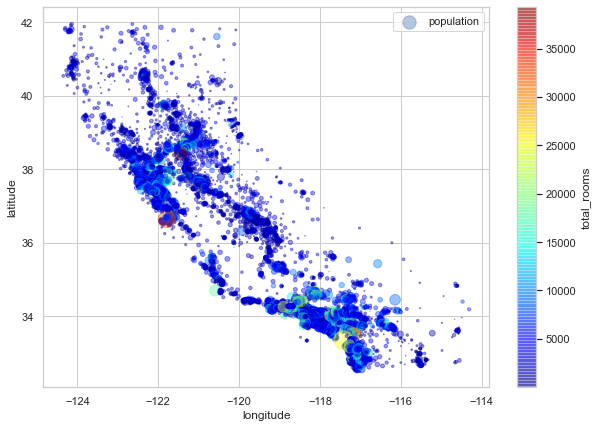

In [22]:
#Plot "total_rooms"
df.plot(kind="scatter", 
        x="longitude", 
        y="latitude", 
        alpha=0.4,
        s=df["population"]/100, 
        label="population", 
        figsize=(10,7),
        c="total_rooms", 
        cmap=plt.get_cmap("jet"), 
        colorbar=True,
        sharex=False)

plt.legend();

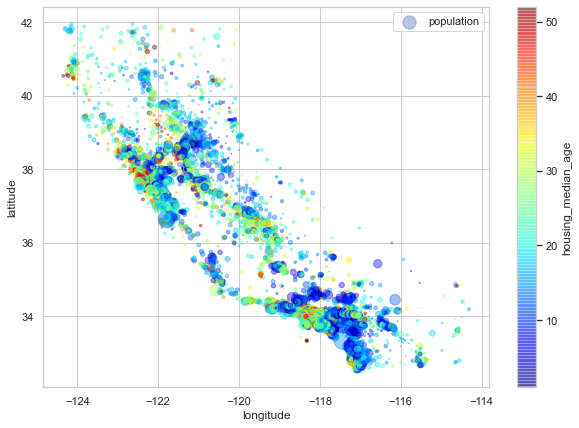

In [23]:
#Plot "housing_median_age"
df.plot(kind="scatter", 
        x="longitude", 
        y="latitude", 
        alpha=0.4,
        s=df["population"]/100, 
        label="population", 
        figsize=(10,7),
        c="housing_median_age", 
        cmap=plt.get_cmap("jet"), 
        colorbar=True,
        sharex=False)

plt.legend();

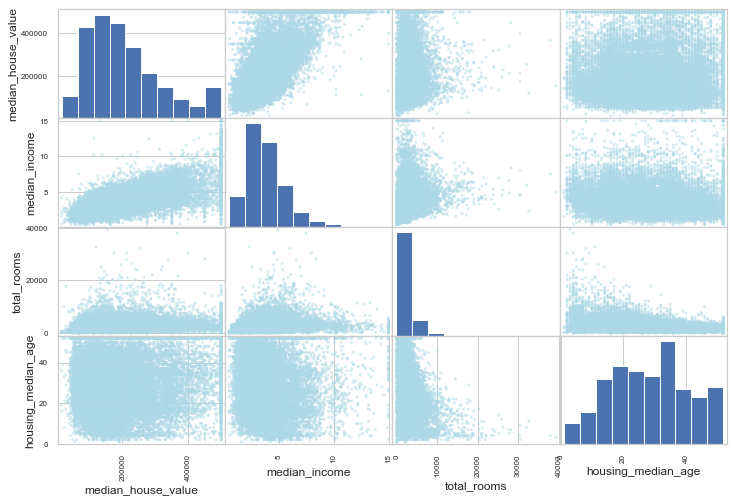

In [24]:
features=["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(df[features], figsize=(12, 8), c='lightblue');

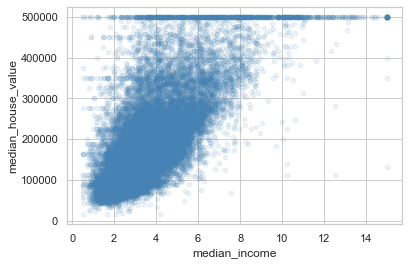

In [25]:
#Take a closer look to the correlation between median income and median house value
df.plot(kind="scatter", x="median_income", y="median_house_value", c='steelblue',alpha=0.1);

The price cap is clearly visible as a horizontal line at usd 500,000. But this plot reveals other less obvious straight lines: a horizontal line around usd 450,000, another around usd 350,000, perhaps one around usd 280,000, and a few more below that.

# 3. Feature engineer

#### Dealing with missing values

In [26]:
median=df['total_bedrooms'].median()
df['total_bedrooms'].fillna(median, inplace=True)
print("Number of null values in total bedrooms column: {}".format(df['total_bedrooms'].isnull().sum()))

Number of null values in total bedrooms column: 0


#### Creating new features

In [27]:
#Rooms per household
df["rooms_per_household"] = df["total_rooms"]/df["households"]

#Bedrooms per room
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]

#Population per household
df["population_per_household"]=df["population"]/df["households"]

#Housing median age per median income
df["housing_age_per_income"]=df["housing_median_age"]/df["median_income"]


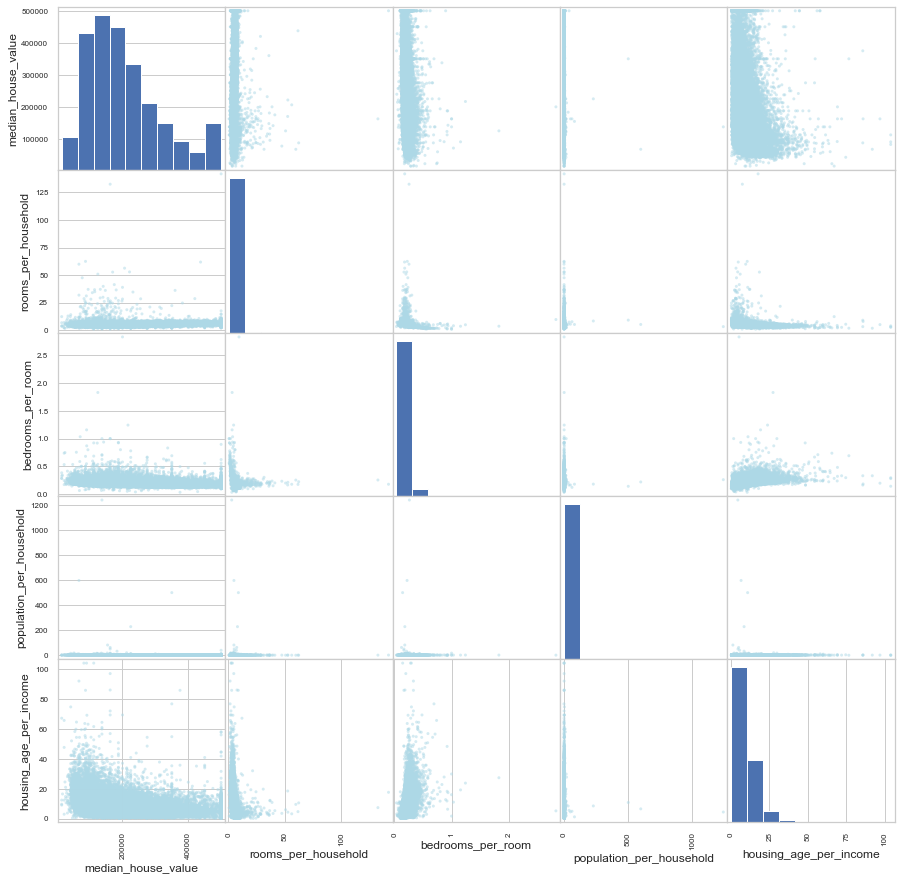

In [28]:
features=["median_house_value","rooms_per_household", "bedrooms_per_room", "population_per_household","housing_age_per_income"]
scatter_matrix(df[features], figsize=(15, 15), c='lightblue');

In [29]:
#Let's take a look to the correlation with the target, given this new features
correlation=df.corr(method="pearson")
correlation['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.233303
housing_age_per_income     -0.320028
Name: median_house_value, dtype: float64

In [30]:
#In absolute values
correlation_abs=abs(correlation['median_house_value']).sort_values(ascending=False)
correlation_abs

median_house_value          1.000000
median_income               0.688075
housing_age_per_income      0.320028
bedrooms_per_room           0.233303
rooms_per_household         0.151948
latitude                    0.144160
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
longitude                   0.045967
population                  0.024650
population_per_household    0.023737
Name: median_house_value, dtype: float64

#### Converting categorical data into a numeric data

In [31]:
ocean_proximity_dumies=pd.get_dummies(df['ocean_proximity'], drop_first=True)
df=df.drop(columns=['ocean_proximity'])
df=pd.concat([df,ocean_proximity_dumies],axis=1)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,housing_age_per_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,4.924807,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,2.529694,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,7.165100,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,9.214793,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,13.519838,0,0,1,0


In [32]:
df.shape

(20640, 17)

#### Preparing the dataset for the split

As the median income is a very important attribute to predict median housing prices, I want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

<AxesSubplot:>

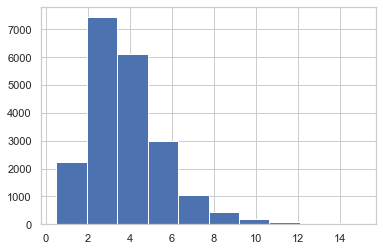

In [33]:
df["median_income"].hist()

In [34]:
df["income_categorical"] = pd.cut(df["median_income"],
                                         #bins=[0., 0.07, 0.173, 0.277, 0.38, np.inf],
                                  bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                  labels=[1, 2, 3, 4, 5])

In [35]:
df["income_categorical"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_categorical, dtype: int64

<AxesSubplot:>

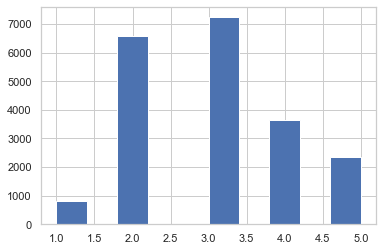

In [36]:
df["income_categorical"].hist()

Now I can do stratified sampling based on the income category, but first, I will scale the features

#### Feature scaling

In [37]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.902266,0.043512,0.039261,0.001499,0.046122,0.0,0.0,1.0,0.0,1.00
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.708247,0.038224,0.042563,0.001141,0.023067,0.0,0.0,1.0,0.0,1.00
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.695051,0.052756,0.033135,0.001698,0.067686,0.0,0.0,1.0,0.0,1.00
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0.672783,0.035241,0.052845,0.001493,0.087416,0.0,0.0,1.0,0.0,0.75
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0.674638,0.038534,0.048410,0.001198,0.128856,0.0,0.0,1.0,0.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130,0.130105,0.029769,0.067255,0.001503,0.152947,1.0,0.0,0.0,0.0,0.25
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853,0.128043,0.037344,0.063876,0.001956,0.066483,1.0,0.0,0.0,0.0,0.25
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764,0.159383,0.030904,0.063864,0.001314,0.094975,1.0,0.0,0.0,0.0,0.25
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295,0.143713,0.031783,0.065557,0.001152,0.091510,1.0,0.0,0.0,0.0,0.25


In [38]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household', 'housing_age_per_income', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'income_categorical'],
      dtype='object')

In [39]:
#I transform the array into a dataframe, so as to concatenate then and have the entire dataset
df_scaled=DataFrame(df_scaled)
df_scaled=df_scaled.rename(columns={0: 'longitude', 
                                    1: 'latitude',
                                    2: 'housing_median_age',
                                    3: 'total_rooms',
                                    4: 'total_bedrooms',
                                    5: 'population',
                                    6: 'households', 
                                    7: 'median_income',
                                    8: 'median_house_value',
                                    9: 'rooms_per_household',
                                   10: 'bedrooms_per_room',
                                   11: 'population_per_household',
                                   12: 'housing_age_per_income',
                                   13: 'INLAND',
                                   14: 'ISLAND',
                                   15: 'NEAR BAY',
                                   16: 'NEAR OCEAN',
                                   17: 'income_categorical'})


df_scaled.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,housing_age_per_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,income_categorical
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.902266,0.043512,0.039261,0.001499,0.046122,0.0,0.0,1.0,0.0,1.0
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.708247,0.038224,0.042563,0.001141,0.023067,0.0,0.0,1.0,0.0,1.0
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.695051,0.052756,0.033135,0.001698,0.067686,0.0,0.0,1.0,0.0,1.0


In [40]:
df_scaled.shape

(20640, 18)

#### Train Test Split

In [41]:
split = StratifiedShuffleSplit(n_splits=1, 
                               test_size=0.2, 
                               random_state=42)

for train_index, test_index in split.split(df_scaled, df_scaled["income_categorical"]):
    strat_train_set = df_scaled.loc[train_index]
    strat_test_set = df_scaled.loc[test_index]

In [42]:
strat_test_set["income_categorical"].value_counts() / len(strat_test_set)

0.50    0.350533
0.25    0.318798
0.75    0.176357
1.00    0.114583
0.00    0.039729
Name: income_categorical, dtype: float64

In [43]:
#Check if the proportoins mantein if we analyze the whole dataset
df["income_categorical"].value_counts() / len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_categorical, dtype: float64

In [44]:
strat_train_set.shape

(16512, 18)

In [45]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,housing_age_per_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,income_categorical
17606,0.245020,0.504782,0.725490,0.039829,0.054314,0.019816,0.055583,0.152019,0.560000,0.026791,0.066977,0.001128,0.133980,0.0,0.0,0.0,0.0,0.25
18632,0.241036,0.479277,0.254902,0.017219,0.016605,0.008492,0.018418,0.408374,0.671339,0.036599,0.043733,0.001622,0.019703,0.0,0.0,0.0,0.0,1.00
14650,0.712151,0.024442,0.588235,0.049596,0.072936,0.026150,0.075810,0.162908,0.375052,0.023954,0.073233,0.001073,0.102976,0.0,0.0,0.0,1.0,0.25
3230,0.472112,0.400638,0.470588,0.046925,0.057418,0.040836,0.057885,0.095447,0.064538,0.031094,0.058731,0.002771,0.126454,1.0,0.0,0.0,0.0,0.25
3555,0.573705,0.179596,0.313725,0.167608,0.236499,0.124891,0.240421,0.174811,0.493814,0.025943,0.069664,0.001896,0.052639,0.0,0.0,0.0,0.0,0.50


In [46]:
strat_test_set.shape

(4128, 18)

In [47]:
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,housing_age_per_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,income_categorical
5241,0.593625,0.167906,0.549020,0.163920,0.156890,0.061128,0.157704,0.536662,1.000000,0.041609,0.042985,0.001274,0.032424,0.0,0.0,0.0,0.0,1.00
10970,0.646414,0.130712,0.745098,0.105728,0.101490,0.046694,0.106890,0.283527,0.464536,0.039291,0.043171,0.001506,0.080130,0.0,0.0,0.0,0.0,0.75
20351,0.527888,0.177471,0.509804,0.110764,0.143544,0.059054,0.143891,0.173239,0.418969,0.029261,0.062916,0.001381,0.085006,0.0,0.0,0.0,0.0,0.50
6568,0.617530,0.176408,1.000000,0.045374,0.047331,0.028448,0.052787,0.251852,0.344537,0.033322,0.048137,0.001987,0.119277,1.0,0.0,0.0,0.0,0.50
13285,0.664343,0.162593,0.607843,0.045094,0.048572,0.029821,0.049498,0.243969,0.219176,0.035667,0.050134,0.002286,0.075008,1.0,0.0,0.0,0.0,0.50


In [48]:
strat_train_set.drop("income_categorical", axis=1, inplace=True)
strat_test_set.drop("income_categorical", axis=1, inplace=True)

#### Defining the target

In [60]:
housing_train = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_train_target = strat_train_set["median_house_value"].copy()

In [58]:
housing_train.shape

(16512, 16)

In [59]:
housing_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'housing_age_per_income', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

In [62]:
housing_train_target.shape

(16512,)

In [63]:
housing_test = strat_test_set.drop("median_house_value", axis=1) # drop labels for test set
housing_test_target = strat_test_set["median_house_value"].copy()

In [64]:
housing_test.shape

(4128, 16)

In [65]:
housing_test_target.shape

(4128,)

# 4. Model selection

#### Linear Regression

In [69]:
lin_reg = LinearRegression()
lin_reg.fit(housing_train, housing_train_target)

LinearRegression()

In [81]:
housing_train_predictions = lin_reg.predict(housing_train)
housing_test_predictions = lin_reg.predict(housing_test)

error_df=pd.Series({'train': mean_squared_error(housing_train_target, housing_train_predictions),
                    'test' : mean_squared_error(housing_test_target, housing_test_predictions)},)

error_df

train    0.019996
test     0.019083
dtype: float64

In [85]:
r2_score(housing_test_target,housing_test_predictions)

0.6555425196337148

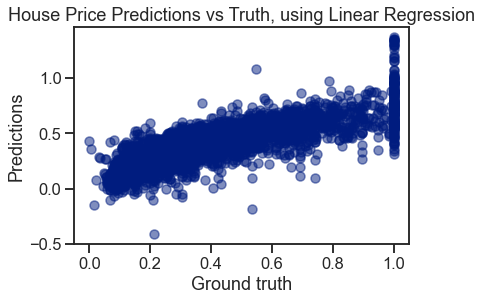

In [82]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()

# we are going to use y_test, y_test_pred
ax.scatter(housing_test_target, housing_test_predictions, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='House Price Predictions vs Truth, using Linear Regression');

In [180]:
pd.DataFrame({'Y_Test': housing_test_target,'Y_Pred':housing_test_predictions}).head(5)

,Y_Test,Y_Pred
5241,1.000000,0.841057
10970,0.464536,0.517783
20351,0.418969,0.440224
6568,0.344537,0.392806
13285,0.219176,0.311012


#### Lasso

In [109]:
pf = PolynomialFeatures(degree=2, include_bias=False)
housing_train_pf = pf.fit_transform(df[:-1])

In [110]:
las_pf = Lasso(random_state=42,selection='random')
las_pf.fit(housing_train_pf, housing_train_target)
las_pf.coef_ 

array([-0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
        0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
        0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0.,
       -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
       -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [111]:
las = Lasso(random_state=42,selection='random')
las.fit(housing_train, housing_train_target)
las.coef_ 

array([-0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,
        0.,  0.,  0.])

In [112]:
las_01 = Lasso(alpha = 0.1,random_state=42,selection='random')
las_01.fit(housing_train, housing_train_target)
print('sum of coefficients:', abs(las_01.coef_).sum() )
print('number of coefficients not equal to 0:', (las_01.coef_!=0).sum())

sum of coefficients: 0.0
number of coefficients not equal to 0: 0


Lasso doesn't work, as all the coefficients are turned to zero

#### Ridge

In [122]:
r = Ridge(alpha = 0.1, random_state=42)

In [123]:
r.fit(housing_train, housing_train_target)

Ridge(alpha=0.1, random_state=42)

In [124]:
housing_train_predictions_r = r.predict(housing_train)
housing_test_predictions_r = r.predict(housing_test)

error_df=pd.Series({'train': mean_squared_error(housing_train_target, housing_train_predictions_r),
                    'test' : mean_squared_error(housing_test_target, housing_test_predictions_r)},)

error_df

train    0.020000
test     0.019089
dtype: float64

In [125]:
r2_score(housing_test_target,housing_test_predictions_r)

0.655434922189142

#### Elastic net

In [134]:
elastic = ElasticNet(random_state=42)
elastic.fit(housing_train, housing_train_target)

ElasticNet(random_state=42)

In [135]:
housing_train_predictions_el = elastic.predict(housing_train)
housing_test_predictions_el = elastic.predict(housing_test)

error_df=pd.Series({'train': mean_squared_error(housing_train_target, housing_train_predictions_el),
                    'test' : mean_squared_error(housing_test_target, housing_test_predictions_el)},)

error_df

train    0.056908
test     0.055402
dtype: float64

In [136]:
r2_score(housing_test_target,housing_test_predictions_el)

-3.50167699068038e-05

#### Decision Tree Regressor

In [137]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_train, housing_train_target)

DecisionTreeRegressor(random_state=42)

In [138]:
housing_train_predictions_dt = tree_reg.predict(housing_train)
housing_test_predictions_dt = tree_reg.predict(housing_test)

error_df=pd.Series({'train': mean_squared_error(housing_train_target, housing_train_predictions_dt),
                    'test' : mean_squared_error(housing_test_target, housing_test_predictions_dt)},)

error_df

train    2.239453e-36
test     2.141052e-02
dtype: float64

In [139]:
r2_score(housing_test_target,housing_test_predictions_dt)

0.6135305701797974

GridSearch

In [156]:
model_basic=DecisionTreeRegressor(random_state=42).fit(housing_train, housing_train_target)

#Creating a dictionary grid for grid search
param_grid = {'max_depth':range(1, model_basic.tree_.max_depth+1, 2), 
              'min_samples_leaf':[10,20,30,40,50],
              'max_features':range(1, len(model_basic.feature_importances_)+1)}

#Creating a dictionary grid for scoring search
#scoring = {"r2_score": "r2", 
#           "mean_squared_error": make_scorer(mean_squared_error)}


#Fitting grid search to the train data with 5 folds
gridsearch_model_basic = GridSearchCV(estimator=model_basic,
                                   param_grid= param_grid,
                                   #cv=StratifiedKFold(), 
                                   n_jobs=-1, 
                                   scoring="r2",
                                   #refit="r2",
                                   verbose=2)

gridsearch_dt_basic=gridsearch_model_basic.fit(housing_train, housing_train_target)

Fitting 5 folds for each of 1520 candidates, totalling 7600 fits


In [157]:
print("Best parameters: "+str(gridsearch_dt_basic.best_params_))
print("Best score: "+str(gridsearch_dt_basic.best_score_)+'\n')

Best parameters: {'max_depth': 17, 'max_features': 13, 'min_samples_leaf': 20}
Best score: 0.7483620603396248



In [158]:
tree_reg = DecisionTreeRegressor(random_state=42,
                                 max_depth= 17, 
                                 max_features= 13, 
                                 min_samples_leaf= 20)

tree_reg.fit(housing_train, housing_train_target)

DecisionTreeRegressor(max_depth=17, max_features=13, min_samples_leaf=20,
                      random_state=42)

In [159]:
housing_train_predictions_dtgs = tree_reg.predict(housing_train)
housing_test_predictions_dtgs = tree_reg.predict(housing_test)

error_df=pd.Series({'train': mean_squared_error(housing_train_target, housing_train_predictions_dtgs),
                    'test' : mean_squared_error(housing_test_target, housing_test_predictions_dtgs)},)

error_df

train    0.009963
test     0.013740
dtype: float64

In [160]:
r2_score(housing_test_target,housing_test_predictions_dtgs)

0.7519956112600878

#### Random Forest Regressor

In [174]:
random_reg = RandomForestRegressor(random_state=42, 
                                   bootstrap= False)
random_reg.fit(housing_train, housing_train_target)

RandomForestRegressor(bootstrap=False, random_state=42)

In [175]:
housing_train_predictions_rf = random_reg.predict(housing_train)
housing_test_predictions_rf = random_reg.predict(housing_test)

error_df=pd.Series({'train': mean_squared_error(housing_train_target, housing_train_predictions_rf),
                    'test' : mean_squared_error(housing_test_target, housing_test_predictions_rf)},)

error_df

train    2.975708e-31
test     2.029180e-02
dtype: float64

In [176]:
r2_score(housing_test_target,housing_test_predictions_rf)

0.6337239576147082

GridSearch

In [177]:
model_basic=RandomForestRegressor(random_state=42,bootstrap= False).fit(housing_train, housing_train_target)

#Creating a dictionary grid for grid search
param_grid = {'max_depth': [30,40,50],
              'min_samples_leaf':[10,40,50],
              'max_features': ['sqrt', 'log2'],
              'n_estimators':[500,700,800,900]}

#Creating a dictionary grid for scoring search
#scoring = {"r2_score": "r2", 
#           "mean_squared_error": make_scorer(mean_squared_error)}


#Fitting grid search to the train data with 5 folds
gridsearch_model_basic = GridSearchCV(estimator=model_basic,
                                   param_grid= param_grid,
                                   #cv=StratifiedKFold(), 
                                   n_jobs=-1, 
                                   scoring="r2",
                                   #refit="r2",
                                   verbose=2)

gridsearch_rf_basic=gridsearch_model_basic.fit(housing_train, housing_train_target)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [181]:
print("Best parameters: "+str(gridsearch_rf_basic.best_params_))
print("Best score: "+str(gridsearch_rf_basic.best_score_)+'\n')

Best parameters: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 900}
Best score: 0.803512281092391



In [182]:
random_reg = RandomForestRegressor(random_state=42,
                                   bootstrap= False,
                                   max_depth= 40, 
                                   max_features= 'sqrt', 
                                   min_samples_leaf= 10,
                                   n_estimators=900)

random_reg.fit(housing_train, housing_train_target)

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      min_samples_leaf=10, n_estimators=900, random_state=42)

In [172]:
housing_train_predictions_rfgs = random_reg.predict(housing_train)
housing_test_predictions_rfgs = random_reg.predict(housing_test)

error_df=pd.Series({'train': mean_squared_error(housing_train_target, housing_train_predictions_rfgs),
                    'test' : mean_squared_error(housing_test_target, housing_test_predictions_rfgs)},)

error_df

train    0.011552
test     0.012515
dtype: float64

In [183]:
r2_score(housing_test_target,housing_test_predictions_rfgs)

0.7740983064449678

#### Conclutions

In [ ]:
def train_show_results(model, housing_train, housing_train_target, housing_test, housing_test_target):
    
    model.fit(housing_train, housing_train_target)
    train_preds = model.predict(housing_train)
    test_preds= model.predict(housing_test)
    
    train_error=np.sqrt(mean_squared_error(housing_train_target, train_preds))
    
    scores=-cross_val_score(model, housing_train, housing_train_target, 
                      scoring='neg_mean_squared_error', cv=10)
    scores_mean=scores.mean()
        
    test_error=np.sqrt(mean_squared_error(housing_test, test_preds))
    
    return type(model).__name__, train_error, ('%.2f'%scores_mean), ('%.2f'%test_error), r2_score(housing_test_target, test_preds)

In [ ]:
models=[lin_reg, Lasso(), Ridge(), ElasticNet(), tree_reg, random_reg]
results={'model':[], 'train_rmse':[], 'cross_val_score': [], 'test_rmse':[], 'r2_score':[]}

In [ ]:
for model in models:
    res=train_show_results(model, X_train, Y_train, test_data, Y_test)
    results['model'].append(res[0])
    results['train_rmse'].append(res[1])
    results['cross_val_score'].append(res[2])
    results['test_rmse'].append(res[3])
    results['r2_score'].append(res[4])

In [ ]:
results=pdDataFrame(results)
results

#### Determining normality in our target variable
Making our target variable normally distributed often will lead to better results

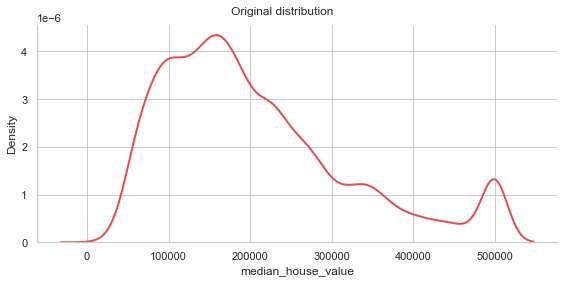

In [53]:
y=df.median_house_value
ax=sns.displot(y, kind = "kde",color="#e64e4e", height=4, aspect=2, linewidth=2)
ax.fig.suptitle('Original distribution',size=12)
plt.show()

In [54]:
df['median_house_value'].skew()

0.9777632739098341

In [55]:
#Does not look normal due to that right tail. Let's try to verify statistically:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

This is a statistical test that tests whether a distribution is normally distributed or not. It isn't perfect, but suffice it to say:
* This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
* Frequentist statisticians would say that you accept that the distribution is normal (more specifically: fail to reject the null hypothesis that it is normal) if p > 0.05.

In [56]:
normaltest(df.median_house_value.values)

NormaltestResult(statistic=2430.931051066072, pvalue=0.0)

I conclude it's not normally distributed (pvalue=0).
Let's try some common transformations to try and get y to be normally distributed:
* Log
* Square root
* Box cox

#### Testing log

NormaltestResult(statistic=359.5441835709363, pvalue=8.432814311339089e-79)


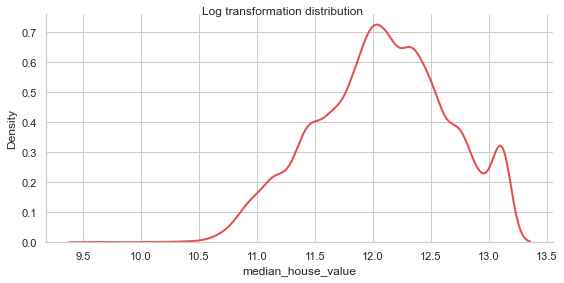

In [57]:
log_medhouseval=np.log(df.median_house_value)

print(normaltest(log_medhouseval.values))

ax=sns.displot(log_medhouseval, kind="kde", color="#e64e4e", height=4, aspect=2, linewidth=2)
ax.fig.suptitle('Log transformation distribution',size=12)

plt.show()

Still not normally distributed

In [58]:
print(log_medhouseval.mean())
print(log_medhouseval.median())

12.084884185522181
12.099044072771651


In [59]:
log_medhouseval.skew()

-0.17317539032496318

#### Square root transformation

NormaltestResult(statistic=851.8425227299555, pvalue=1.0586355256019327e-185)


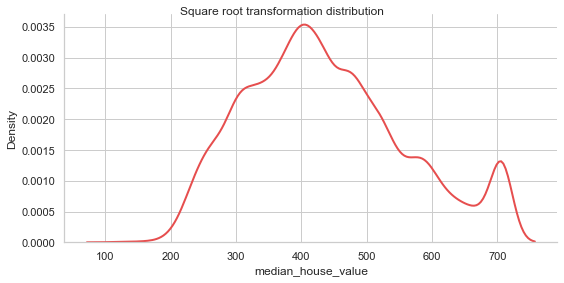

In [60]:
sqrt_medhouseval=np.sqrt(df.median_house_value)

print(normaltest(sqrt_medhouseval.values))

ax=sns.displot(sqrt_medhouseval, kind="kde", color="#e64e4e", height=4, aspect=2, linewidth=2)
ax.fig.suptitle('Square root transformation distribution',size=12)

plt.show()

Still not normally distributed

In [61]:
print(sqrt_medhouseval.mean())
print(sqrt_medhouseval.median())

437.9702725941846
423.9103678845329


In [62]:
sqrt_medhouseval.skew()

0.43938209295248964

#### Box cox

In [63]:
from scipy.stats import boxcox

In [64]:
boxcox_result=boxcox(df.median_house_value)
boxcox_medhouseval=boxcox_result[0]
lam=boxcox_result[1]

In [65]:
lam

0.12474766902508995

NormaltestResult(statistic=446.7475254302457, pvalue=9.772539868057055e-98)


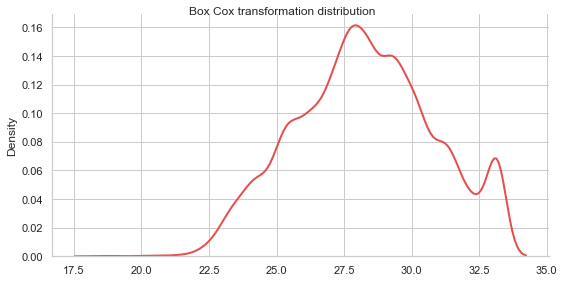

In [66]:
print(normaltest(boxcox_medhouseval))

ax=sns.displot(boxcox_medhouseval, kind="kde", color="#e64e4e", height=4, aspect=2, linewidth=2)
ax.fig.suptitle('Box Cox transformation distribution',size=12)

plt.show()

In [67]:
pd.Series(boxcox_medhouseval).skew()

-0.012149399033377103

#### Reciprocal transformation

NormaltestResult(statistic=10918.17910928709, pvalue=0.0)


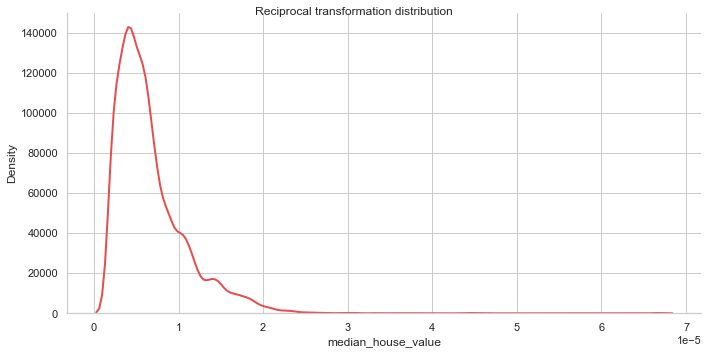

In [68]:
rec_medhouseval = 1/df.median_house_value

print(normaltest(rec_medhouseval))

ax=sns.displot(rec_medhouseval, kind="kde", color="#e64e4e", height=5, aspect=2, linewidth=2)
ax.fig.suptitle('Reciprocal transformation distribution',size=12)

plt.show()

In [69]:
print(rec_medhouseval.mean())
print(rec_medhouseval.median())

6.659519019630361e-06
5.564830272676683e-06


In [70]:
rec_medhouseval.skew()

2.2068536679056394

The best results, though not perfect, are given by the **boxcox transformation.**

In [71]:
#Target
y=boxcox(df.median_house_value)[0]
y

array([32.67541821, 31.50929663, 31.4205773 , ..., 25.35448606,
       24.99868342, 25.22185574])